In [ ]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy
import gc

root = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.join(root,'imStat','code'))
import utils
import model_src
import other_model_code


In [ ]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

In [ ]:
# Loading a set of images

from scipy import io
import h5py

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = io.loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from utils import load_nsd

n_samples = 5000
trn_stim_data = load_nsd.image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:n_samples]]

images = trn_stim_data

In [ ]:
# Parameters

from model_src import rf_grid

n_ori=8;
n_sf=3

cyc_per_stim = rf_grid.logspace(n_sf)(3., 72.)
orient_step  = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)

process_at_size = [227,227]

batch_size=2

In [ ]:
## Complex Cells

from model_src import gabor_feature_extractor_new as gabor_feature_extractor

def _to_torch(x, device=None):
    return torch.from_numpy(x).float().to(device) 

def get_value(_x):
    return np.copy(_x.data.cpu().numpy())

pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer_complex = gabor_feature_extractor.Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', padding_mode='circular',
          crop=False).to(device)


orient_filters_complex = _gaborizer_complex.orient_filters    

maps_complex = _gaborizer_complex(_to_torch(images[0:batch_size],device=device))
maps_complex = [maps_complex[sf].detach().cpu().numpy() for sf in range(len(maps_complex))]

print(np.shape(maps_complex[0]))

# Simple Cells
_gaborizer_simple = gabor_feature_extractor.Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=False, pad_type='half', padding_mode='circular',
          crop=False).to(device)

# NOTE THIS MODEL HAS TWICE AS MANY FILTERS, TWO PER ORIENTATION (EVEN/ODD SYMMETRIC)
orient_filters_simple = _gaborizer_simple.orient_filters    
phase_values = _gaborizer_simple.phase_values
n_phases = len(phase_values)
simple_cell_orient_ind_list = np.repeat(np.arange(n_ori), n_phases)
simple_cell_phase_ind_list = np.tile(np.arange(n_phases), n_ori)

maps_simple =  _gaborizer_simple(_to_torch(images[0:batch_size],device=device))
maps_simple = [maps_simple[sf].detach().cpu().numpy() for sf in range(len(maps_simple))]

print(np.shape(maps_simple[0]))


In [ ]:
# Plotting first level feature maps (simple cells)

image_ind = 1

orient_ind_list = np.repeat(np.arange(n_ori), 2)
phase_ind_list = np.tile(np.arange(len(phase_values)), n_ori)

ori2plot = np.array([6,6,7,7]).astype('int')
sf2plot = np.array([0,0,2,2]).astype('int')
phase2plot = np.array([0,1,0,1]).astype('int')

plt.figure(figsize=(22,6));

plt.subplot(1,5,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in  range(len(sf2plot)):
    
    xx = np.where(np.logical_and(orient_ind_list==ori2plot[ii], phase_ind_list==phase2plot[ii]))[0][0];
   
    plt.subplot(1,5,2+ii)
    plt.pcolormesh(maps_simple[sf2plot[ii]][image_ind,xx,:,:])

    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('orient = %d deg, phase = %.2f\nSF = %.2f cyc/stim'%(orients_deg[ori2plot[ii]],phase_values[phase2plot[ii]],cyc_per_stim[sf2plot[ii]]))
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle('examples of simple cell-like linear filters')

In [ ]:
# Plotting first level feature maps (complex cells)

image_ind = 1

ori2plot = (np.array([0,5,6,7])).astype('int')
sf2plot = np.array([0,1,1,2]).astype('int')

plt.figure(figsize=(22,6));

plt.subplot(1,5,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in  range(len(sf2plot)):

    plt.subplot(1,5,2+ii)
    plt.pcolormesh(maps_complex[sf2plot[ii]][image_ind,ori2plot[ii],:,:])

    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cyc/stim'%(orients_deg[ori2plot[ii]],cyc_per_stim[sf2plot[ii]]))
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle('examples of complex cell-like second order filters')  

In [ ]:
# define spatial RF regions to use

n_prfs = 5
xvals = np.linspace(-0.5, 0, 5)
yvals = 0*np.ones(np.shape(xvals))
sigmavals = 0.09*np.ones(np.shape(xvals))

from utils import numpy_utility

g = numpy_utility.make_gaussian_mass_stack(xvals,yvals,sigmavals, n_pix=process_at_size[0], size=1.0, dtype=np.float32)
plt.figure(figsize=(20,4))
for mm in range(n_prfs):
    plt.subplot(1,5,mm+1)
    plt.pcolormesh(g[2][mm])
    plt.axis('equal')
    plt.axis('off')
    plt.title('x=%.2f, y=%.2f, sigma=%.2f'%(xvals[mm],yvals[mm],sigmavals[mm]))

In [ ]:
# Plotting first level feature maps, overlaying specified pRF

mm=2
x = xvals[mm]
y = yvals[mm]
sigma=sigmavals[mm]
prf = g[2][mm]
image_ind = 0

ori2plot = (np.array([5,6,7])).astype('int')
sf2plot = np.array([0,1,2]).astype('int')

plt.figure(figsize=(16,16));

plt.subplot(1,4,1)
im2plot = images[image_ind,0,:,:] * prf
plt.pcolormesh(im2plot)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in  range(len(sf2plot)):
    
    this_map = maps_complex[sf2plot[ii]][image_ind,ori2plot[ii],:,:]
    g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=np.shape(this_map)[0], size=1.0, dtype=np.float32)
    prf = g[2][0]
#     ff = np.where(np.logical_and(orient_ind_list==ori2plot[ii], freq_ind_list==sf2plot[ii]))[0][0];
   
    plt.subplot(1,4,2+ii)
#     im2plot = maps_spat[image_ind,:,:,ff] * prf
#     plt.pcolormesh(im2plot)
    plt.pcolormesh(this_map * prf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cyc/stim'%(orients_deg[ori2plot[ii]],cyc_per_stim[sf2plot[ii]]))
    plt.xticks([])
    plt.yticks([])
   

In [ ]:
def weighted_cross_corr_2d(images1, images2, spatial_weights, center=None, pix_from_center=None, subtract_patch_mean=True, device=None):

    """
    Compute cross-correlation of two identically-sized images, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Can optionally specify a square patch of the image to compute over, based on "center" and "pix_from_center" params. Otherwise use whole image.
    Basically a dot product of image values.
    Input parameters:
        center: center (in pixels) of the patch to use for cross-correlation. If "None" this will be center of the image. If specifying weights as something like a Gaussian pRF, this should be the pRF center. 
        pix_from_center: half length of the patch to use for cross-correlation. If "None" this will be the minimum distance from center to any image edge.  Could be for instance pRF standard deviation.
        subtract_patch_mean: do you want to subtract the weighted mean of image patch before computing?
    Returns:
        A single value that captures correlation between images (zero spatial shift)
            
    """
    
    if device is None:
        device = torch.device('cpu:0')  
    if isinstance(images1, np.ndarray):
        images1 = _to_torch(images1, device)
    if isinstance(images2, np.ndarray):
        images2 = _to_torch(images2, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = _to_torch(spatial_weights, device)      
    
    if len(np.shape(images1))==2:
        # pretend the batch and channel dims exist, for 2D input only (3D won't work)
        single_image=True
        images1 = images1.view([1,1,images1.shape[0],-1])
        images2 = images2.view([1,1,images2.shape[0],-1])
    else:
        single_image=False
        
    # have to be same size
    assert(images1.shape==images2.shape)
    assert(images1.shape[2]==spatial_weights.shape[0] and images1.shape[3]==spatial_weights.shape[1])
    assert(images2.shape[2]==spatial_weights.shape[0] and images2.shape[3]==spatial_weights.shape[1])
    # images is [batch_size x n_channels x nPix x nPix]
    batch_size = images1.shape[0]
    n_channels = images1.shape[1]
    

    if center is not None or pix_from_center is not None:
        if center is None:
            center = (int(np.floor(images1.shape[0]/2)), int(np.floor(images1.shape[1]/2)))
        else:
            center = (int(center[0]), int(center[1]))
        if pix_from_center is None:
            pix_from_center = np.min([int(np.floor(images1.shape[0]/2)), np.min([center, images1.shape-np.array(center)])])
        else:
            pix_from_center = int(pix_from_center)
        # first crop out the region of the image that's currently of interest
        images1 = images1[:,:,center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
        images2 = images2[:,:,center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]

    
    # make sure the wts sum to 1
    spatial_weights = spatial_weights/torch.sum(spatial_weights)
    spatial_weights = spatial_weights.view([1,1,spatial_weights.shape[0],-1]).expand([batch_size,n_channels,-1,-1]) # [batch_size x n_channels x nPix x nPix]    
    
    # compute cross-correlation
    if subtract_patch_mean:
        # subtract mean of each weighted image patch and take their dot product.
        # this quantity is equal to weighted covariance (only true if mean-centered)
        wmean1 = torch.sum(torch.sum(images1 * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean1 = wmean1.view([batch_size,-1,1,1]).expand([-1,-1,images1.shape[2],images1.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        wmean2 = torch.sum(torch.sum(images2 * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean2 = wmean2.view([batch_size,-1,1,1]).expand([-1,-1,images2.shape[2],images2.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        weighted_images1 = (images1 - wmean1) * torch.sqrt(spatial_weights) # square root of the weights here because they will get squared again in dot product operation.
        weighted_images2 = (images2 - wmean2) * torch.sqrt(spatial_weights)

        cross_corr = torch.sum(torch.sum(weighted_images1 * weighted_images2, dim=3), dim=2)    

    else:
        # dot product of raw (weighted) values
        # this is closer to what scipy.signal.correlate2d will do (except this is weighted)
        weighted_images1 = images1 * torch.sqrt(spatial_weights)
        weighted_images2 = images2 * torch.sqrt(spatial_weights)
        cross_corr = torch.sum(torch.sum(weighted_images1 * weighted_images2, dim=3), dim=2)      
        
    if single_image:
        cross_corr = torch.squeeze(cross_corr)
        
    return cross_corr



In [230]:
# Testing batched version of crosscorr function

ori1 = 0
ori2 = 1
sf1 = 0
batch_size=10
maps_complex = _gaborizer_complex(_to_torch(images[0:batch_size],device=device))
maps1_batch = torch.unsqueeze(maps_complex[sf1][0:10,ori1,:,:],dim=1)
maps2_batch = torch.unsqueeze(maps_complex[sf1][0:10,ori2,:,:],dim=1)
mm=2
x = xvals[mm]
y = yvals[mm]
sigma=sigmavals[mm]
n_pix=np.shape(maps_complex[sf1])[2]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=1.0, dtype=np.float32)
spatial_weights = g[2][0]
pix_from_center = int(sigma*2*n_pix)
center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))

image_ind=3

sub_mean=True

# Check to make sure batched function gives same results as single-image

cc_batch = get_value(weighted_cross_corr_2d(maps1_batch, maps2_batch, spatial_weights, center, pix_from_center, subtract_patch_mean = sub_mean, device=device))

cc_single2 = get_value(weighted_cross_corr_2d(maps1_batch[image_ind,0,:,:], maps2_batch[image_ind,0,:,:], spatial_weights, center, pix_from_center, subtract_patch_mean = sub_mean, device=device))

cc_single3 = get_value(weighted_cross_corr_2d_single(maps1_batch[image_ind,0,:,:], maps2_batch[image_ind,0,:,:], spatial_weights, center, pix_from_center, subtract_patch_mean = sub_mean, device=device))


print(np.shape(cc_batch))
print(np.shape(cc_single2))
print(np.shape(cc_single3))

print([cc_batch[image_ind,0], cc_single2, cc_single3])

(10, 1)
()
()
[3.5242479e-06, array(3.5242479e-06, dtype=float32), array(3.5242479e-06, dtype=float32)]


In [ ]:
def weighted_auto_corr_2d(images, spatial_weights, center=None, pix_from_center=None, output_pix=None, subtract_patch_mean=False, enforce_size=False, device=None):

    """
    Compute autocorrelation of a batch of images, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Can optionally specify a square patch of the image to compute over, based on "center" and "pix_from_center" params. Otherwise use whole image.
    Using fft method to compute, should be fast.
    Input parameters:
        center: center (in pixels) of the patch to use for autocorrelation. If "None" this will be center of the image. If specifying weights as something like a Gaussian pRF, this should be the pRF center. 
        pix_from_center: half length of the patch to use for autocorrelation. If "None" this will be the minimum distance from center to any image edge.  Could be for instance pRF standard deviation.
        output_pix: the size of the autocorrelation matrix output by this function. If this is an even number, the output size is this value +1. Achieved by cropping out the center of the final autocorrelation 
            matrix  (note that the full image patch is still used in computing the autocorrelation, but just the center values are returned).
            If None, then returns the full autocorrelation matrix (same size as image patch.)
        subtract_patch_mean: subtract weighted mean of image before computing autocorr?
        enforce_size: if image patch is smaller than desired output, should we pad w zeros so that it has to be same size?
    Returns:
        A matrix describing the correlation of the image and various spatially shifted versions of it.
    """
    
    
    if device is None:
        device = torch.device('cpu:0')        
    if isinstance(images, np.ndarray):
        images = _to_torch(images, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = _to_torch(spatial_weights, device)
            
    if len(np.shape(images))==2:
        # pretend the batch and channel dims exist, for 2D input only (3D won't work)
        single_image=True
        images = images.view([1,1,images.shape[0],-1])
    else:
        single_image=False
        
    # have to be same size
    assert(images.shape[2]==spatial_weights.shape[0] and images.shape[3]==spatial_weights.shape[1])
    # images is [batch_size x n_channels x nPix x nPix]
    batch_size = images.shape[0]
    n_channels = images.shape[1]
    
    
    if center is not None or pix_from_center is not None:
        if center is None:
            center = (int(np.floor(np.shape(images)[2]/2)), int(np.floor(np.shape(images)[3]/2)))
        else:
            center = (int(center[0]), int(center[1]))
        if pix_from_center is None:
            pix_from_center = np.min([int(np.floor(np.shape(images)[2]/2)), np.min([center, np.shape(images)-np.array(center)])])
        else:
            pix_from_center = int(pix_from_center)
        # first crop out the region of the image that's currently of interest
        images = images[:,:,center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]

   
    # make sure these sum to 1
    spatial_weights = spatial_weights/torch.sum(spatial_weights)   
    spatial_weights = spatial_weights.view([1,1,spatial_weights.shape[0],-1]).expand([batch_size,n_channels,-1,-1]) # [batch_size x n_channels x nPix x nPix]    
    
    # compute autocorrelation of this image patch
    if subtract_patch_mean:

        wmean = torch.sum(torch.sum(images * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean = wmean.view([batch_size,-1,1,1]).expand([-1,-1,images.shape[2],images.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        weighted_images = (images - wmean) * torch.sqrt(spatial_weights) # square root of the weights here because they will get squared again in next operation
        auto_corr = torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(weighted_images, dim=[2,3]))**2, dim=[2,3])), dim=[2,3]);
    else:
        weighted_images = images * torch.sqrt(spatial_weights)
        auto_corr = torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(weighted_images, dim=[2,3]))**2, dim=[2,3])), dim=[2,3]);

    if output_pix is not None:

        # crop out just the center region
        new_center = int(np.floor(auto_corr.shape[2]/2))
        n_pix_out = np.min([int(np.floor(output_pix/2)), np.min([new_center, auto_corr.shape[2]-new_center])])
        auto_corr = auto_corr[:,:,new_center-n_pix_out:new_center+n_pix_out+1, new_center-n_pix_out:new_center+n_pix_out+1]        
    
    if enforce_size and not (np.shape(auto_corr)[2]==output_pix or np.shape(auto_corr)[2]==output_pix+1):
        
        # just pad w zeros if want same size.
        pix_diff = output_pix - np.shape(auto_corr)[2]   
        auto_corr = torch.nn.functional.pad(auto_corr, [int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2))], mode='constant', value=0)
        assert(np.shape(auto_corr)[2]==output_pix and np.shape(auto_corr)[3]==output_pix)

    if single_image:
        auto_corr = torch.squeeze(auto_corr)
        
    return auto_corr



In [208]:
# Testing batched version of autocorr function

ori1 = 0
ori2 = 1
sf1 = 0
batch_size=10
maps_complex = _gaborizer_complex(_to_torch(images[0:batch_size],device=device))
maps_batch = torch.unsqueeze(maps_complex[sf1][0:10,ori1,:,:],dim=1)
mm=2
x = xvals[mm]
y = yvals[mm]
sigma=sigmavals[mm]
n_pix=np.shape(maps_complex[sf1])[2]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=1.0, dtype=np.float32)
spatial_weights = g[2][0]
pix_from_center = int(sigma*2*n_pix)
center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))

image_ind=3

sub_mean=True

# Check to make sure batched function gives same results as single-image
auto_corr_batch1 = get_value(weighted_auto_corr_2d(maps_batch, _to_torch(spatial_weights, device=device), center, pix_from_center, output_pix=3, subtract_patch_mean =sub_mean, device=device))
auto_corr_single1 = get_value(weighted_auto_corr_2d(maps_batch[image_ind,0,:,:], spatial_weights, center, pix_from_center, output_pix=3, subtract_patch_mean =sub_mean, device=device))

# also checking to make sure numpy inputs work too
auto_corr_batch2 = get_value(weighted_auto_corr_2d(get_value(maps_batch),spatial_weights, center, pix_from_center, output_pix=3, subtract_patch_mean =sub_mean, device=device))
auto_corr_single3 = get_value(weighted_auto_corr_2d(get_value(maps_batch[image_ind,0,:,:]), spatial_weights, center, pix_from_center, output_pix=3, subtract_patch_mean =sub_mean, device=device))

auto_corr_single3 = get_value(weighted_auto_corr_2d_single(maps_batch[image_ind,0,:,:], spatial_weights, center, pix_from_center, output_pix=3, subtract_patch_mean =sub_mean, device=device))

print(np.shape(auto_corr_batch))
print(np.shape(auto_corr_single1))
print(np.shape(auto_corr_single3))

print([auto_corr_batch1[image_ind,0,0,0], auto_corr_batch2[image_ind,0,0,0], auto_corr_single1[0,0], auto_corr_single2[0,0], auto_corr_single3[0,0]])

(10, 1, 3, 3)
(3, 3)
(3, 3)
[7.8536044e-07, 7.8536044e-07, 7.8536044e-07, 7.8536044e-07, 7.8536044e-07]


In [ ]:
# Compare my cross-correlation and auto-correlation fns to other methods for sanity check...

# fns from
# https://github.com/CcgAlberta/pygeostat/blob/master/pygeostat/statistics/utils.py

def weighted_correlation(x, y, wt):
    """Calculates the weighted correlation"""
    return (weighted_covariance(x, y, wt) /
            (np.sqrt(weighted_variance(x, wt)) * np.sqrt(weighted_variance(y, wt))))

def weighted_covariance(x, y, wt):
    """Calculates the weighted covariance"""
    return (np.average((x - weighted_mean(x, wt)) *
                       (y - weighted_mean(y, wt)), weights=wt))

def weighted_variance(var, wts):
    """Calculates the weighted variance"""
    return np.average((var - weighted_mean(var, wts))**2, weights=wts)

def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)

# grab two example feature maps as inputs
ori1 = 0
ori2 = 1
sf1 = 0
image_ind=0
image1 = get_value(maps_complex[sf1][image_ind,ori1,:,:])
image2 = get_value(maps_complex[sf1][image_ind,ori2,:,:])

# grab an example prf at same size
mm=2
x = xvals[mm]
y = yvals[mm]
sigma=sigmavals[mm]
n_pix=np.shape(maps_complex[sf1])[2]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=1.0, dtype=np.float32)
spatial_weights = g[2][0]
# decide on the window to use for correlations, based on prf parameters. Patch goes 2 SD from the center.
pix_from_center = int(sigma*2*n_pix)
center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))

image1_cropped = image1[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
image2_cropped = image2[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
spatial_weights_cropped = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]



# Weighted covariance is same as my weighted cross-correlation.
wcov = weighted_covariance(image1_cropped, image2_cropped, spatial_weights_cropped)
wcor = weighted_correlation(image1_cropped, image2_cropped, spatial_weights_cropped)
wvar1 = weighted_variance(image1_cropped,spatial_weights_cropped)
wvar2 = weighted_variance(image2_cropped,spatial_weights_cropped)
cross_corr = torch.squeeze(weighted_cross_corr_2d(image1, image2, spatial_weights, center, pix_from_center, subtract_patch_mean =True)).numpy()
# same value...
print([wcov, wcor*np.sqrt(wvar1)*np.sqrt(wvar2), cross_corr])
       
# If you put in same array twice it's autocorrelation.
wautocov = weighted_covariance(image1_cropped, image1_cropped, spatial_weights_cropped)
wvar = weighted_variance(image1_cropped, spatial_weights_cropped)
# Center of the autocorr matrix is zero spatial shift, same as the variance.
auto_corr = torch.squeeze(weighted_auto_corr_2d(image1, spatial_weights, center, pix_from_center, output_pix=3, subtract_patch_mean =True)).numpy()
# same values...
print([wautocov, wvar, auto_corr[1,1]])


In [349]:
def get_higher_order_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params, sample_batch_size=20, autocorr_output_pix=7, n_prf_sd_out=2, aperture=1.0, device=None):

    """
    Compute all higher-order features (cross-spatial and cross-feature correlations) for a batch of images.
    Input the functions that define first level feature maps (simple and complex cells), and prf parameters.
    Returns arrays of each higher order feature.    
    """
    
    if device is None:
        device = torch.device('cpu:0')    
        
    n_trials = np.shape(images)[0]
    
    assert(np.mod(autocorr_output_pix,2)==1) # must be odd!

    n_features_simple, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_simple, images[0:sample_batch_size], device)
    n_features_complex, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_complex, images[0:sample_batch_size], device)
    
    n_sf = len(fmaps_rez)
    n_ori = int(n_features_complex/n_sf)
    n_phases = 2
    
    # all pairs of different orientation channels.
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]

    complex_feature_autocorrs = np.zeros([n_trials, n_sf, n_ori, autocorr_output_pix**2])
    simple_feature_autocorrs = np.zeros([n_trials, n_sf, n_ori, n_phases, autocorr_output_pix**2])

    complex_within_scale_crosscorrs = np.zeros([n_trials, n_sf, n_ori_pairs])
    simple_within_scale_crosscorrs = np.zeros([n_trials, n_sf, n_phases, n_ori_pairs])

    complex_across_scale_crosscorrs = np.zeros([n_trials, n_sf-1, n_ori, n_ori])
    simple_across_scale_crosscorrs = np.zeros([n_trials, n_sf-1, n_phases, n_ori, n_ori]) # only done for pairs of neighboring SF.

    x,y,sigma = prf_params

    bb=-1
    for batch_inds, batch_size_actual in numpy_utility.iterate_range(0, n_trials, sample_batch_size):
        bb=bb+1
        
        fmaps_complex = _fmaps_fn_complex(_to_torch(images[batch_inds],device=device))   
        fmaps_simple =  _fmaps_fn_simple(_to_torch(images[batch_inds],device=device))

        # First looping over frequency (scales)
        for ff in range(n_sf):

            # Scale specific things - get the prf at this resolution of interest
            n_pix = fmaps_rez[ff]
            g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
            spatial_weights = g[2][0]
            # decide on the window to use for correlations, based on prf parameters. Patch goes # SD from the center (2 by default).
            pix_from_center = int(sigma*n_prf_sd_out*n_pix)
            center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))

            # Loop over orientation channels
            xx=-1
            for oo1 in range(n_ori):       


                # Simple cell responses - loop over two phases per orient.
                for pp in range(n_phases):
                    filter_ind = n_phases*oo1+pp  # orients and phases are both listed in the same dimension of filters matrix               
                    simple1 = fmaps_simple[ff][:,filter_ind,:,:].view([batch_size_actual,1,n_pix,n_pix])

                    # Simple cell autocorrelations.
                    auto_corr = get_value(weighted_auto_corr_2d(simple1, spatial_weights, center, pix_from_center, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)) 
                    simple_feature_autocorrs[batch_inds,ff,oo1,pp,:] = np.reshape(auto_corr, [batch_size_actual, autocorr_output_pix**2])

                # Complex cell responses
                complex1 = fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])

                # Complex cell autocorrelation (correlation w spatially shifted versions of itself)
                auto_corr = get_value(weighted_auto_corr_2d(complex1, spatial_weights, center, pix_from_center, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device))       
                complex_feature_autocorrs[batch_inds,ff,oo1,:] = np.reshape(auto_corr, [batch_size_actual, autocorr_output_pix**2])

                # Within-scale correlations - compare resp at orient==oo1 to responses at all other orientations, same scale.
                for oo2 in np.arange(oo1+1, n_ori):            
                    xx = xx+1 
                    assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                    complex2 = fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])      

                    # Complex cell within-scale cross correlations
                    cross_corr = get_value(weighted_cross_corr_2d(complex1, complex2, spatial_weights, center, pix_from_center, subtract_patch_mean = True, device=device))
                   
                    complex_within_scale_crosscorrs[batch_inds,ff,xx] = np.squeeze(cross_corr);

                    # Simple cell within-scale cross correlations
                    for pp in range(n_phases):
                        filter_ind = n_phases*oo2+pp
                        simple2 = fmaps_simple[ff][:,filter_ind,:,:].view([batch_size_actual,1,n_pix,n_pix])

                        cross_corr = get_value(weighted_cross_corr_2d(simple1, simple2, spatial_weights, center, pix_from_center, subtract_patch_mean = True, device=device))
                        simple_within_scale_crosscorrs[batch_inds,ff,pp,xx] = np.squeeze(cross_corr);

                # Cross-scale correlations - for these we care about same ori to same ori, so looping over all ori.
                # Only for neighboring scales, so the first level doesn't get one
                if ff>0:

                    for oo2 in range(n_ori):

                        # Complex cell response for neighboring scale
                        complex2_neighborscale = fmaps_complex[ff-1][:,oo2,:,:].view([batch_size_actual,1,fmaps_rez[ff-1], -1])
                        # Resize so that it can be compared w current scale
                        complex2_neighborscale = torch.nn.functional.interpolate(complex2_neighborscale, [n_pix, n_pix], mode='bilinear', align_corners=True)

                        cross_corr = get_value(weighted_cross_corr_2d(complex1, complex2_neighborscale, spatial_weights, center, pix_from_center, subtract_patch_mean = True, device=device))
                        complex_across_scale_crosscorrs[batch_inds,ff-1, oo1, oo2] = np.squeeze(cross_corr)

                        for pp in range(n_phases):
                            filter_ind = n_phases*oo2+pp
                            # Simple cell response for neighboring scale
                            simple2_neighborscale = fmaps_simple[ff-1][:,filter_ind,:,:].view([batch_size_actual,1,fmaps_rez[ff-1], -1])
                            simple2_neighborscale = torch.nn.functional.interpolate(simple2_neighborscale, [n_pix, n_pix], mode='bilinear', align_corners=True)

                            cross_corr = get_value(weighted_cross_corr_2d(simple1, simple2_neighborscale, spatial_weights, center, pix_from_center, subtract_patch_mean = True, device=device))
                            simple_across_scale_crosscorrs[batch_inds,ff-1, pp, oo1, oo2] = np.squeeze(cross_corr)

    
        
    return complex_feature_autocorrs, simple_feature_autocorrs, complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, complex_across_scale_crosscorrs, simple_across_scale_crosscorrs

In [350]:
# Gather all the higher level features

n_trials = 5000
_fmaps_fn_complex =_gaborizer_complex
_fmaps_fn_simple = _gaborizer_simple
sample_batch_size=100
autocorr_output_pix=7;
n_prf_sd_out=2;
aperture=1.0

mm=2
x = xvals[mm]
y = yvals[mm]
sigma=sigmavals[mm]

t = time.time()
complex_feature_autocorrs, simple_feature_autocorrs, \
complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, \
complex_across_scale_crosscorrs, simple_across_scale_crosscorrs = get_higher_order_features(_fmaps_fn_complex, _fmaps_fn_simple, images[0:n_trials,:,:,:], prf_params=[x,y,sigma], 
                                                                                            sample_batch_size=sample_batch_size, autocorr_output_pix=autocorr_output_pix, n_prf_sd_out=n_prf_sd_out, aperture=aperture, device=device)
elapsed =  time.time() - t
print('time elapsed = %.5f'%elapsed)

all_feat_concat = np.concatenate((np.reshape(complex_feature_autocorrs, [n_trials,-1]), np.reshape(simple_feature_autocorrs, [n_trials,-1]), 
                                  np.reshape(complex_within_scale_crosscorrs, [n_trials,-1]), np.reshape(simple_within_scale_crosscorrs, [n_trials,-1]),
                                  np.reshape(complex_across_scale_crosscorrs, [n_trials,-1]), np.reshape(simple_across_scale_crosscorrs, [n_trials,-1])), axis=1)

np.shape(all_feat_concat)

time elapsed = 38.58354


(5000, 4164)

In [261]:
# Gather the low-level features

from model_src import fwrf_fit

_fmaps_fn_complex =_gaborizer_complex
_fmaps_fn_simple = _gaborizer_simple
sample_batch_size = 10
aperture=1.0

t = time.time()
complex_feature_means = fwrf_fit.get_features_in_prf([x,y,sigma], _fmaps_fn_complex , images=images, sample_batch_size=sample_batch_size, aperture=aperture, device=device)
elapsed =  time.time() - t
print('time elapsed = %.5f'%elapsed)

t = time.time()
simple_feature_means = fwrf_fit.get_features_in_prf([x,y,sigma],  _fmaps_fn_simple, images=images, sample_batch_size=sample_batch_size, aperture=aperture, device=device)
elapsed =  time.time() - t
print('time elapsed = %.5f'%elapsed)

print(np.shape(complex_feature_means))
print(np.shape(simple_feature_means))

time elapsed = 6.25969
time elapsed = 3.47948
(5000, 24)
(5000, 48)


In [276]:
def get_weighted_pixel_features(image_batch, spatial_weights, device=None):
    """
    Compute mean, variance, skewness, kurtosis of luminance values for each of a batch of images.
    Input size is [batch_size x n_channels x npix x npix]
    Spatial weights describes a weighting function, [npix x npix]
    Returns [batch_size x n_channels] size array for each property.
    """
    
    if isinstance(image_batch, np.ndarray):
        image_batch = _to_torch(image_batch)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = _to_torch(spatial_weights)
     
    assert(image_batch.shape[2]==spatial_weights.shape[0] and image_batch.shape[3]==spatial_weights.shape[1])
    assert(image_batch.shape[1]==1)
    
    batch_size = image_batch.shape[0]
    n_channels = image_batch.shape[1]
    n_pix = image_batch.shape[2]

    image_batch = image_batch.view([batch_size, n_channels, n_pix**2])
    spatial_weights = spatial_weights/torch.sum(spatial_weights)
    spatial_weights = spatial_weights.view([1,1,n_pix**2]).expand([batch_size,n_channels,-1]) # [batch_size x n_channels x nPix x nPix]    
   
    ims_weighted = image_batch * spatial_weights
   
    wmean = torch.sum(ims_weighted, axis=2).view([batch_size,-1,1])

    wvar = torch.sum(spatial_weights * (image_batch - wmean.expand([-1,-1,n_pix**2]))**2, axis=2).view([batch_size,-1,1])
    
    wskew = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**3 / (wvar**(3/2)), axis=2).view([batch_size,-1,1])
    
    wkurt = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**4 / (wvar**(2)), axis=2).view([batch_size,-1,1])
    
    return torch.squeeze(wmean, dim=2), torch.squeeze(wvar, dim=2), torch.squeeze(wskew, dim=2), torch.squeeze(wkurt, dim=2)


In [277]:
# Testing my pixel statistic function against these other functions that are written in numpy

# from http://www.ccgalberta.com/pygeostat/statistics.html#weighted-statistics

def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)


def weighted_variance(var, wts):
    """Calculates the weighted variance"""
    return np.average((var - weighted_mean(var, wts))**2, weights=wts)


def weighted_skew(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**3, weights=wts) /
            weighted_variance(var, wts)**(1.5))

def weighted_kurtosis(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**4, weights=wts) /
            weighted_variance(var, wts)**(2))

n_pix=np.shape(images)[2]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=1.0, dtype=np.float32)
spatial_weights = g[2][0]

print(weighted_mean(np.ravel(images[0,0,:,:]), np.ravel(spatial_weights)))
print(weighted_variance(np.ravel(images[0,0,:,:]), np.ravel(spatial_weights)))
print(weighted_skew(np.ravel(images[0,0,:,:]), np.ravel(spatial_weights)))
print(weighted_kurtosis(np.ravel(images[0,0,:,:]), np.ravel(spatial_weights)))


wmean, wvar, wskew, wkurt = get_weighted_pixel_features(images, spatial_weights, device=device)

print([wmean[0,0], wvar[0,0], wskew[0,0], wkurt[0,0]])

0.45633394
0.06109989
0.3662430612888606
1.9544982637682522
[tensor(0.4563), tensor(0.0611), tensor(0.3662), tensor(1.9545)]


In [280]:
# Gather the pixel features


t=time.time()
wmean, wvar, wskew, wkurt = get_weighted_pixel_features(images, spatial_weights, device=device)
elapsed =  time.time() - t
print('time elapsed = %.5f'%elapsed)


print(np.shape(wmean))
print(np.shape(wvar))
print(np.shape(wskew))
print(np.shape(wkurt))

time elapsed = 1.77959
torch.Size([5000, 1])
torch.Size([5000, 1])
torch.Size([5000, 1])
torch.Size([5000, 1])


In [353]:
n_trials = 5000
images[0:n_trials,:,:,:]

mm=4
prf_params = [xvals[mm], yvals[mm], sigmavals[mm]]
_fmaps_fn_complex =_gaborizer_complex
_fmaps_fn_simple = _gaborizer_simple
sample_batch_size = 100
aperture=1.0
n_trials = 5000
autocorr_output_pix=5;
n_prf_sd_out=2;

all_feat_concat, feature_info = compute_all_texture_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params, sample_batch_size, autocorr_output_pix, n_prf_sd_out, aperture, device=device)

Computing pixel-level statistics...
time elapsed = 1.77993
Computing complex cell features...
time elapsed = 5.13502
Computing simple cell features...
time elapsed = 2.95759
Computing higher order correlations...
time elapsed = 42.22571
Concatenating features...


In [354]:
np.shape(all_feat_concat)

(5000, 2512)

In [356]:
feature_info[1]

['wmean',
 'wvar',
 'wskew',
 'wkurt',
 'complex_feature_means',
 'simple_feature_means',
 'complex_feature_autocorrs',
 'simple_feature_autocorrs',
 'complex_within_scale_crosscorrs',
 'simple_within_scale_crosscorrs',
 'complex_across_scale_crosscorrs',
 'simple_across_scale_crosscorrs']

In [352]:
# Gather all the features.

from collections import OrderedDict

def compute_all_texture_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params, sample_batch_size=100, autocorr_output_pix=3, n_prf_sd_out=2, aperture=1.0, device=None):

    x,y,sigma = prf_params
    n_pix=np.shape(images)[2]
    g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
    spatial_weights = g[2][0]

    print('Computing pixel-level statistics...')
    t=time.time()
    wmean, wvar, wskew, wkurt = get_weighted_pixel_features(images, spatial_weights, device=device)
    elapsed =  time.time() - t
    print('time elapsed = %.5f'%elapsed)
 
    print('Computing complex cell features...')
    t = time.time()
    complex_feature_means = fwrf_fit.get_features_in_prf(prf_params, _fmaps_fn_complex , images=images, sample_batch_size=sample_batch_size, aperture=aperture, device=device)
    elapsed =  time.time() - t
    print('time elapsed = %.5f'%elapsed)
    
    print('Computing simple cell features...')
    t = time.time()
    simple_feature_means = fwrf_fit.get_features_in_prf(prf_params,  _fmaps_fn_simple, images=images, sample_batch_size=sample_batch_size, aperture=aperture, device=device)
    elapsed =  time.time() - t
    print('time elapsed = %.5f'%elapsed)

    print('Computing higher order correlations...')
    t = time.time()
    complex_feature_autocorrs, simple_feature_autocorrs, \
    complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, \
    complex_across_scale_crosscorrs, simple_across_scale_crosscorrs = get_higher_order_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params=prf_params, 
                                                                                                sample_batch_size=sample_batch_size, autocorr_output_pix=autocorr_output_pix, n_prf_sd_out=n_prf_sd_out, aperture=aperture, device=device)
    elapsed =  time.time() - t
    print('time elapsed = %.5f'%elapsed)

    print('Concatenating features...')
    all_feat = OrderedDict({'wmean': get_value(wmean), 'wvar':get_value(wvar), 'wskew':get_value(wskew), 'wkurt':get_value(wkurt), 'complex_feature_means':complex_feature_means, 'simple_feature_means':simple_feature_means, 
            'complex_feature_autocorrs': np.reshape(complex_feature_autocorrs, [n_trials,-1]), 'simple_feature_autocorrs': np.reshape(simple_feature_autocorrs, [n_trials,-1]), 
            'complex_within_scale_crosscorrs': np.reshape(complex_within_scale_crosscorrs, [n_trials,-1]), 'simple_within_scale_crosscorrs': np.reshape(simple_within_scale_crosscorrs, [n_trials,-1]),
            'complex_across_scale_crosscorrs': np.reshape(complex_across_scale_crosscorrs, [n_trials,-1]), 'simple_across_scale_crosscorrs':np.reshape(simple_across_scale_crosscorrs, [n_trials,-1])})

    feature_names = list(all_feat.keys())

    for ff, feature_name in enumerate(feature_names): 
        if ff==0:
            all_feat_concat = all_feat[feature_name]
            feature_type_labels = ff*np.ones([1,all_feat[feature_name].shape[1]])
        else:    

            all_feat_concat = np.concatenate((all_feat_concat, all_feat[feature_name]), axis=1)
            feature_type_labels = np.concatenate((feature_type_labels, ff*np.ones([1,all_feat[feature_name].shape[1]])), axis=1)

    return all_feat_concat, [feature_type_labels, feature_names]

In [376]:
models = np.array([xvals, yvals, sigmavals]).transpose()
models.shape

(5, 3)

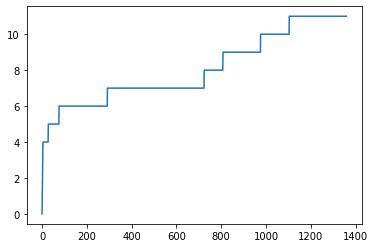

In [333]:
plt.figure()
plt.plot(np.transpose(feature_type_labels))

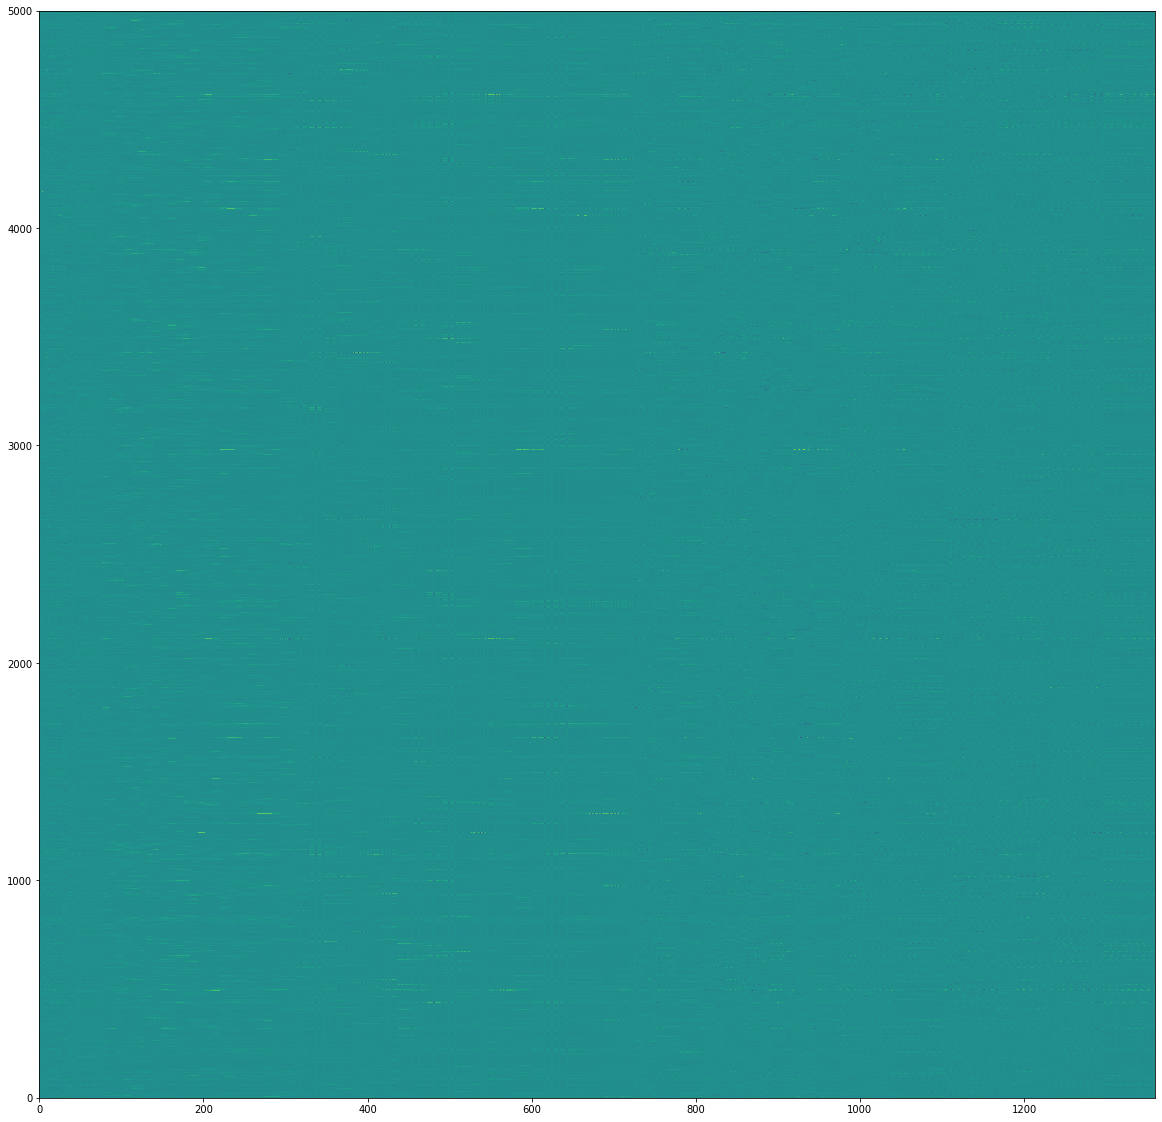

In [334]:
plt.figure(figsize=(20,20));
plt.pcolormesh(scipy.stats.zscore(all_feat_concat, axis=0))

In [335]:
# how many features will be needed, in total?
n_ori_pairs=28
n_phases=2
4 + n_ori*n_sf + n_ori*n_sf*n_phases + n_ori*n_sf*autocorr_output_pix**2 + n_ori*n_sf*n_phases*autocorr_output_pix**2 + n_sf*n_ori_pairs + n_sf*n_ori_pairs*n_phases + (n_sf-1)*n_ori**2 + (n_sf-1)*n_ori**2*n_phases

1360

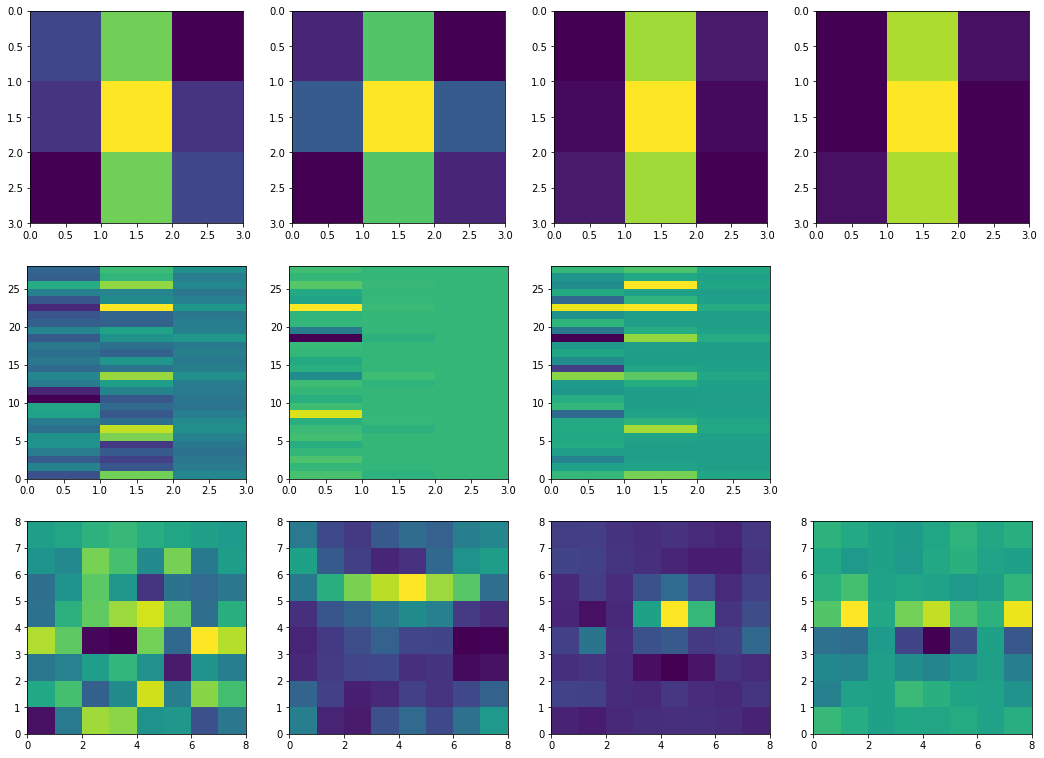

In [338]:
# visualizing some of the higher-order statistics

plt.figure(figsize=(18,18))
npx=4; npy=4
plt.subplot(npx,npy,1)
plt.pcolormesh(np.reshape(complex_feature_autocorrs[0,0,0,:], [autocorr_output_pix, autocorr_output_pix]))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,2)
plt.pcolormesh(np.reshape(complex_feature_autocorrs[0,2,0,:], [autocorr_output_pix, autocorr_output_pix]))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,3)
plt.pcolormesh(np.reshape(simple_feature_autocorrs[0,0,0,0,:], [autocorr_output_pix, autocorr_output_pix]))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,4)
plt.pcolormesh(np.reshape(simple_feature_autocorrs[0,0,0,1,:], [autocorr_output_pix, autocorr_output_pix]))
plt.axis('square')
plt.gca().invert_yaxis()


# cross-feature correlation matrix, [nori x nsf]
plt.subplot(npx,npy,5)
plt.pcolormesh(np.transpose(complex_within_scale_crosscorrs[0,:,:]))

plt.subplot(npx,npy,6)
plt.pcolormesh(np.transpose(simple_within_scale_crosscorrs[0,:,0,:]))

plt.subplot(npx,npy,7)
plt.pcolormesh(np.transpose(simple_within_scale_crosscorrs[0,:,1,:]))

plt.subplot(npx,npy,9)
plt.pcolormesh(np.transpose(complex_across_scale_crosscorrs[0,0,:,:]))

plt.subplot(npx,npy,10)
plt.pcolormesh(np.transpose(complex_across_scale_crosscorrs[0,1,:,:]))

plt.subplot(npx,npy,11)
plt.pcolormesh(np.transpose(simple_across_scale_crosscorrs[0,0,0,:,:]))

plt.subplot(npx,npy,12)
plt.pcolormesh(np.transpose(simple_across_scale_crosscorrs[0,0,1,:,:]))


elapsed = 0.00860

elapsed = 0.00197

elapsed = 0.00178



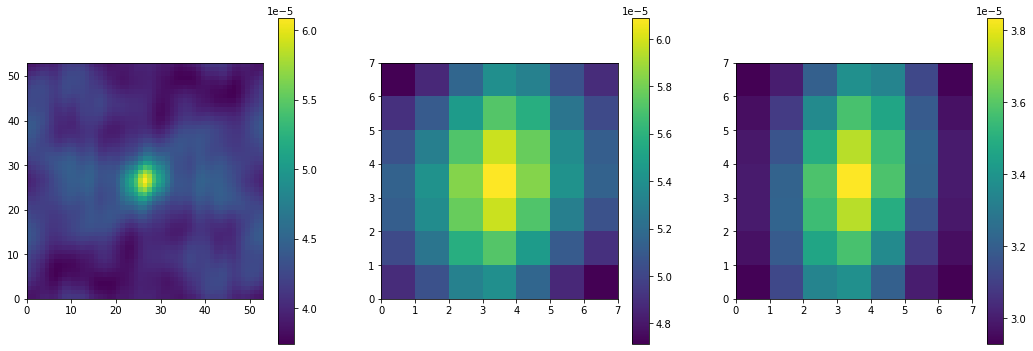

In [339]:
# Test resizing of autocorrelation matrix

image_ind = 0
ori2plot = 0
sf2plot = 2

image = maps_complex[sf2plot][image_ind,ori2plot,:,:]
n_pix=np.shape(image)[0]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=1.0, dtype=np.float32)
prf = g[2][0]
spatial_weights = prf;
# spatial_weights = np.ones(np.shape(prf))
output_pix = 6;

# decide on the window to use for autocorrelation, based on prf parameters. 
pix_from_center = int(sigma*n_pix)
center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))

# center=None

# return full autocorr matrix
t=time.time();
auto_corr = get_value(weighted_auto_corr_2d(image, spatial_weights, center, pix_from_center, output_pix=None, device=device))
elapsed = time.time() - t;
print('elapsed = %.5f\n'%elapsed)

# crop out the desired region at center
t=time.time();
auto_corr2 = get_value(weighted_auto_corr_2d(image, spatial_weights, center, pix_from_center, output_pix, device=device))
elapsed = time.time() - t;
print('elapsed = %.5f\n'%elapsed)

# crop the image to small region before computing autocorr
t=time.time();
auto_corr3 = get_value(weighted_auto_corr_2d(image, spatial_weights, center, pix_from_center=7, output_pix=output_pix, device=device))
elapsed = time.time() - t;
print('elapsed = %.5f\n'%elapsed)

plt.figure(figsize=(18,6));

plt.subplot(1,3,1)
plt.pcolormesh(auto_corr)
plt.axis('square')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(auto_corr2)
plt.axis('square')
plt.colorbar()
# plt.title('scipy correlate2d');

plt.subplot(1,3,3)
plt.pcolormesh(auto_corr3)
plt.axis('square')
plt.colorbar()
# plt.title('fft operations pytorch');

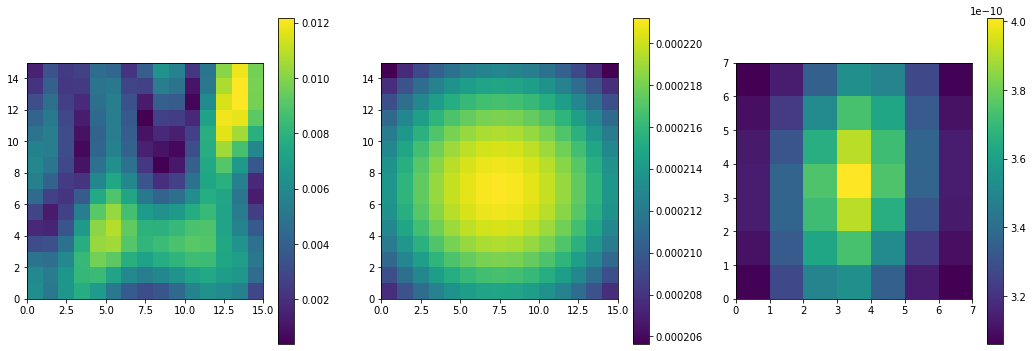

In [340]:
# testing how results differ w different patch sizes

# spatial_weights = np.ones(np.shape(prf))
spatial_weights = prf
center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))
pix_from_center=7
image_cropped = image[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
weights_cropped = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
auto_corr = get_value(torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(image_cropped*_to_torch(weights_cropped, device)))**2))));

new_center = int(np.floor(auto_corr.shape[0]/2))
n_pix_out = np.min([int(np.floor(output_pix/2)), np.min([new_center, auto_corr.shape[0]-new_center])])
auto_corr = auto_corr[new_center-n_pix_out:new_center+n_pix_out+1, new_center-n_pix_out:new_center+n_pix_out+1]


plt.figure(figsize=(18,6));

plt.subplot(1,3,1)
plt.pcolormesh(get_value(image_cropped))
plt.axis('square')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(weights_cropped)
plt.axis('square')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(auto_corr)
plt.axis('square')
plt.colorbar()

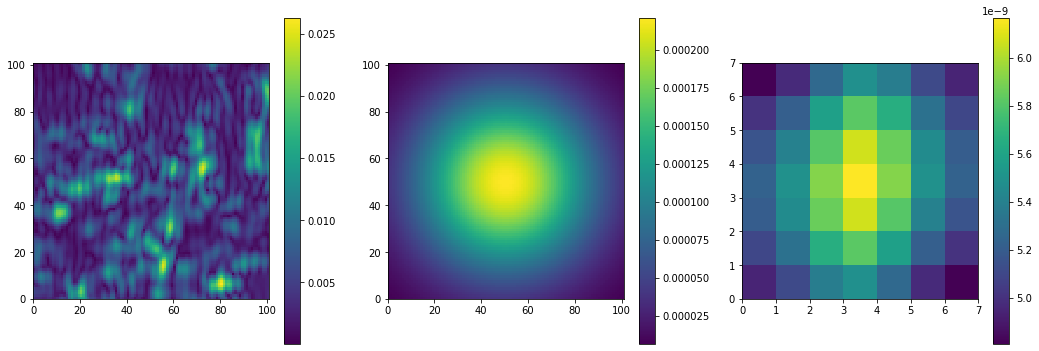

In [341]:
# testing how results differ w different patch sizes
# spatial_weights = np.ones(np.shape(prf))
spatial_weights = prf
center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))
pix_from_center=50
image_cropped = image[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
weights_cropped = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
auto_corr = get_value(torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(image_cropped*_to_torch(weights_cropped, device)))**2))));

new_center = int(np.floor(auto_corr.shape[0]/2))
n_pix_out = np.min([int(np.floor(output_pix/2)), np.min([new_center, auto_corr.shape[0]-new_center])])
auto_corr = auto_corr[new_center-n_pix_out:new_center+n_pix_out+1, new_center-n_pix_out:new_center+n_pix_out+1]


plt.figure(figsize=(18,6));

plt.subplot(1,3,1)
plt.pcolormesh(get_value(image_cropped))
plt.axis('square')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(weights_cropped)
plt.axis('square')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(auto_corr)
plt.axis('square')
plt.colorbar()

elapsed = 0.00257

elapsed = 0.03629

elapsed = 0.00134

elapsed = 0.00128



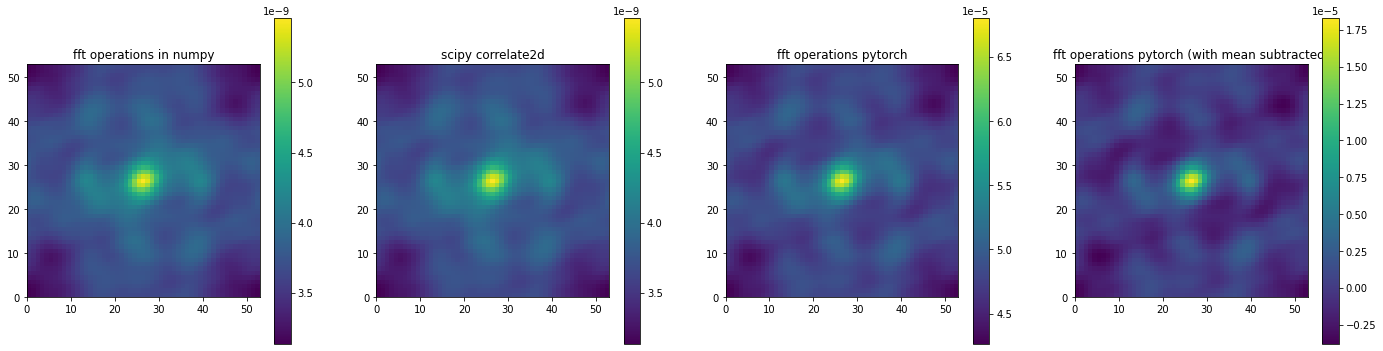

In [342]:
# Test my weighted autocorr method, and also compare to scipy's built-in autocorr function.
from scipy import signal

image_ind = 0
ori2plot = 5
sf2plot = 2

image = maps_complex[sf2plot][image_ind,ori2plot,:,:]
n_pix=np.shape(image)[0]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=1.0, dtype=np.float32)
prf = g[2][0]
spatial_weights = prf;

# decide on the window to use for autocorrelation, based on prf parameters. 
pix_from_center = int(sigma*n_pix)
center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))
t=time.time();
auto_corr1 = weighted_auto_corr_2d_fft_numpy(get_value(image), spatial_weights, center, pix_from_center)
elapsed = time.time() - t;
print('elapsed = %.5f\n'%elapsed)
t=time.time();
auto_corr2 = weighted_auto_corr_2d_scipy(get_value(image), spatial_weights, center, pix_from_center)
elapsed = time.time() - t;
print('elapsed = %.5f\n'%elapsed)
t=time.time();
auto_corr3 = torch.squeeze(weighted_auto_corr_2d(image, spatial_weights, center, pix_from_center, subtract_patch_mean = False, device=device))
elapsed = time.time() - t;
print('elapsed = %.5f\n'%elapsed)

t=time.time();
auto_corr4 = torch.squeeze(weighted_auto_corr_2d(image, spatial_weights, center, pix_from_center, subtract_patch_mean = True, device=device))
elapsed = time.time() - t;
print('elapsed = %.5f\n'%elapsed)

plt.figure(figsize=(24,6));

plt.subplot(1,4,1)
plt.pcolormesh(auto_corr1)
plt.axis('square')
plt.colorbar()
plt.title('fft operations in numpy');

plt.subplot(1,4,2)
plt.pcolormesh(auto_corr2)
plt.axis('square')
plt.colorbar()
plt.title('scipy correlate2d');

plt.subplot(1,4,3)
plt.pcolormesh(get_value(auto_corr3))
plt.axis('square')
plt.colorbar()
plt.title('fft operations pytorch');

plt.subplot(1,4,4)
plt.pcolormesh(get_value(auto_corr4))
plt.axis('square')
plt.colorbar()
plt.title('fft operations pytorch (with mean subtracted)');

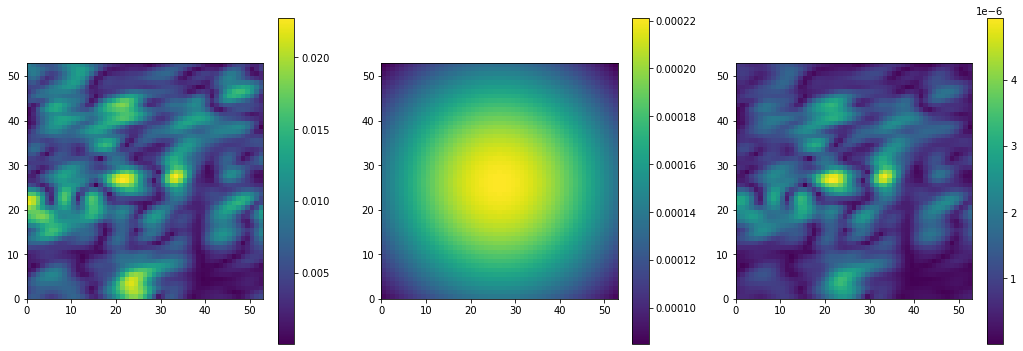

In [343]:
# plotting the region of the image that was used for autocorrelation

plt.figure(figsize=(18,6));

image = get_value(image)

plt.subplot(1,3,1)
plt.pcolormesh(image[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1])
plt.axis('square')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1])
# plt.pcolormesh(spatial_weights)
plt.axis('square')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(image[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1] * spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1])
plt.axis('square')
plt.colorbar()

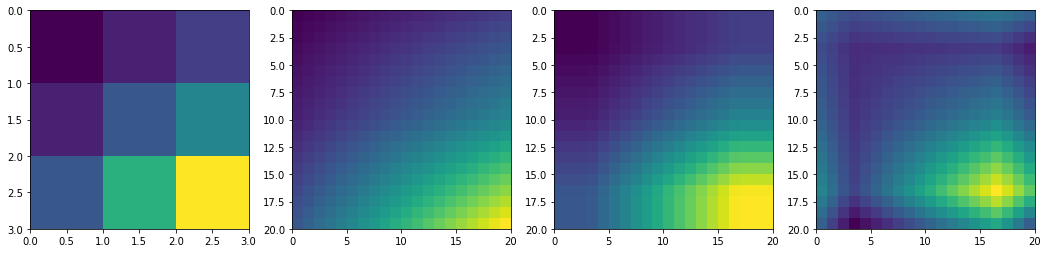

In [344]:
# Comparing some of the diff ways to interpolate/resize images


thing = np.array([[1,2,3],[2,4,6],[4,8,12]])
newsize = [20,20]
resized_1 = torch.nn.functional.interpolate(_to_torch(thing).view([1,1,3,3]), newsize, mode='bilinear', align_corners=True)
upfn = torch.nn.Upsample(newsize[0], mode="bilinear", align_corners=False)
resized_2 = upfn(_to_torch(thing).view([1,1,3,3]))

plt.figure(figsize=(18,6));

plt.subplot(1,4,1)
plt.pcolormesh(thing)
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,4,2)
plt.pcolormesh(torch.squeeze(resized_1))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,4,3)
plt.pcolormesh(torch.squeeze(resized_2))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,4,4)
plt.pcolormesh(torch.squeeze(resized_2) - torch.squeeze(resized_1))
plt.axis('square')
plt.gca().invert_yaxis()

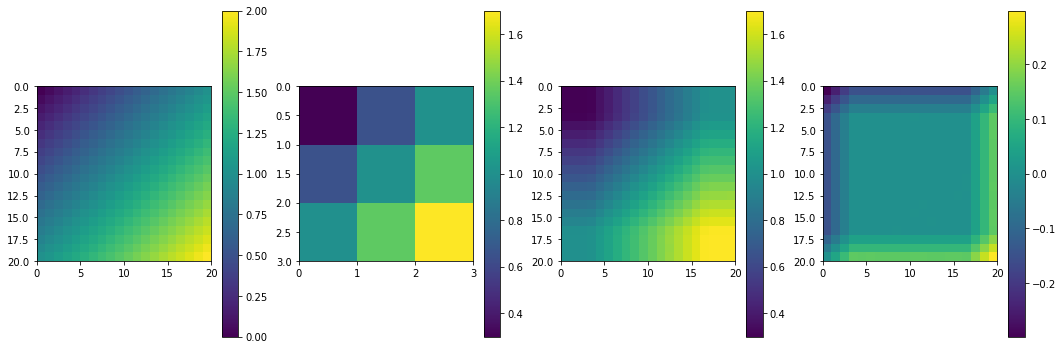

In [345]:
# Comparing some of the diff ways to interpolate/resize images
# align_corners = True seems better

bigsize = [20,20]
xgrid, ygrid = np.meshgrid(np.linspace(0,1,newsize[0]), np.linspace(0,1,newsize[0]))
grad_orig = np.abs(xgrid + ygrid)

smallsize = [3,3]
grad_down =torch.nn.functional.interpolate(_to_torch(grad_orig).view([1,1,bigsize[0], bigsize[1]]), smallsize, mode='bilinear', align_corners=False)
# grad_down =torch.nn.functional.interpolate(_to_torch(grad_orig).view([1,1,bigsize[0], bigsize[1]]), smallsize, mode='bilinear', align_corners=True)
grad_up =torch.nn.functional.interpolate(grad_down, bigsize, mode='bilinear', align_corners=False)
# grad_up =torch.nn.functional.interpolate(grad_down, bigsize, mode='bilinear', align_corners=True)

plt.figure(figsize=(18,6));

plt.subplot(1,4,1)
plt.pcolormesh(grad_orig)
plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,4,2)
plt.pcolormesh(torch.squeeze(grad_down))
plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,4,3)
plt.pcolormesh(torch.squeeze(grad_up))
plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,4,4)
plt.pcolormesh(grad_orig-torch.squeeze(grad_up).numpy())
plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

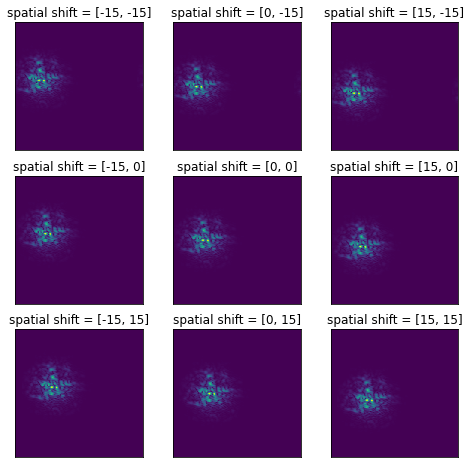

In [346]:
# testing spatially shift map around (as you would do in autocorrelation computation)

image_ind = 0

ori2plot = 5
sf2plot = 2

n_shifts = 3
max_pix_shift = 15
shift_by = np.round(np.linspace(-max_pix_shift, max_pix_shift, n_shifts))
shift_grid_x, shift_grid_y = np.meshgrid(shift_by, shift_by)
shift_grid_x = np.ravel(shift_grid_x).astype('int')
shift_grid_y = np.ravel(shift_grid_y).astype('int')
unx, xinds = np.unique(shift_grid_x, return_inverse=True)
uny, yinds = np.unique(shift_grid_y, return_inverse=True)

auto_corr = np.zeros((len(shift_by), len(shift_by)))

plt.figure(figsize=(8,8));

im2plot = get_value(maps_complex[sf2plot][image_ind,ori2plot,:,:])

g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=np.shape(im2plot)[0], size=1.0, dtype=np.float32)
prf = g[2][0]
im2plot = im2plot * prf

for ii in range(len(shift_grid_x)):
    
    plt.subplot(n_shifts, n_shifts,ii+1)
    
    
    im_spat_shift = np.roll(im2plot, shift_grid_x[ii], axis=0)
    im_spat_shift = np.roll(im_spat_shift, shift_grid_y[ii], axis=1)
    
#     im_spat_shift = im_spat_shift * prf    
#     im_orig_windowed = im2plot * prf
 
    plt.pcolormesh(im_spat_shift)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('spatial shift = [%d, %d]'%(shift_grid_x[ii], shift_grid_y[ii]))
    plt.xticks([])
    plt.yticks([])
    

# plt.suptitle('Spatial shifts\nnorient = %d deg, SF = %.2f cpp'%(orients_deg[ori2plot],cyc_per_stim[sf2plot]))

In [ ]:
def weighted_auto_corr_2d_OLD(image, spatial_weights, n_shifts, shift_size_pix):
    
    """
    Simple (VERY SLOW) method to compute autocorrelation of an image, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Just shift the pixels over and get correlation of shifted ims.
    Never finished/tested but might be useful someday...
    """
    
    shift_by = np.arange(-n_shifts*shift_size_pix, n_shifts*shift_size_pix+1, shift_size_pix)
    shift_grid_x, shift_grid_y = np.meshgrid(shift_by, shift_by)
    shift_grid_x = np.ravel(shift_grid_x).astype('int')
    shift_grid_y = np.ravel(shift_grid_y).astype('int')
    unx, xinds = np.unique(shift_grid_x, return_inverse=True)
    uny, yinds = np.unique(shift_grid_y, return_inverse=True)

    auto_corr = np.zeros((len(shift_by), len(shift_by)))

    for ii in range(len(shift_grid_x)):
    
        im_spat_shift = np.roll(im2plot, shift_grid_x[ii], axis=0)
        im_spat_shift = np.roll(im_spat_shift, shift_grid_y[ii], axis=1)

        im_spat_shift = im_spat_shift * prf    
        im_orig_windowed = im2plot * prf

        auto_corr[xinds[ii], yinds[ii]] = np.dot(np.ravel(im_spat_shift), np.ravel(im_orig_windowed))

    return auto_corr

In [ ]:
def weighted_auto_corr_2d_fft_numpy(image, spatial_weights, center=None, pix_from_center=None):

    """
    OLD VERSION IN NUMPY
    Compute autocorrelation of an image, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Using fft method to compute, should be fast.
    """
    
    
    if center is not None or pix_from_center is not None:
        if center is None:
            center = (int(np.floor(np.shape(image)[0]/2)), int(np.floor(np.shape(image)[1]/2)))
        else:
            center = (int(center[0]), int(center[1]))
        if pix_from_center is None:
            pix_from_center = np.min([int(np.floor(np.shape(image)[0]/2)), np.min([center, np.shape(image)-np.array(center)])])
        else:
            pix_from_center = int(pix_from_center)
        # first crop out the region of the image that's currently of interest
        image = image[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]

    # compute autocorrelation of this image patch
    auto_corr = np.fft.fftshift(np.real(np.fft.ifft2(np.abs(np.fft.fft2(image*spatial_weights))**2)));
 
    return auto_corr



In [ ]:
def weighted_auto_corr_2d_scipy(image, spatial_weights, center=None, pix_from_center=None):

    """
    SCIPY very slow method
    Compute autocorrelation of an image, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).

    """
    
    
    if center is not None or pix_from_center is not None:
        if center is None:
            center = (int(np.floor(np.shape(image)[0]/2)), int(np.floor(np.shape(image)[1]/2)))
        else:
            center = (int(center[0]), int(center[1]))
        if pix_from_center is None:
            pix_from_center = np.min([int(np.floor(np.shape(image)[0]/2)), np.min([center, np.shape(image)-np.array(center)])])
        else:
            pix_from_center = int(pix_from_center)
        # first crop out the region of the image that's currently of interest
        image = image[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]

    # compute autocorrelation of this image patch
    auto_corr = scipy.signal.correlate2d(image*spatial_weights, image*spatial_weights, mode='same', boundary='wrap')
    
    return auto_corr

In [ ]:
def get_higher_order_features_OLD(fmaps_complex, fmaps_simple, image_ind, prf_params, autocorr_output_pix=7, n_prf_sd_out=2):

    """
    Compute all higher-order features (cross-spatial and cross-feature correlations) based on first-level feature maps
    for both simple and complex cells, and a specified pRF position/size.
    Returns arrays of each higher order feature.    
    """
    
    assert(np.mod(autocorr_output_pix,2)==1) # must be odd!

    n_sf = len(fmaps_complex)
    n_ori = fmaps_complex[0].shape[1]
    n_phases = 2
    
    # all pairs of different orientation channels.
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]

    complex_feature_autocorrs = np.zeros([n_sf, n_ori, autocorr_output_pix**2])
    simple_feature_autocorrs = np.zeros([n_sf, n_ori, n_phases, autocorr_output_pix**2])

    complex_within_scale_crosscorrs = np.zeros([n_sf, n_ori_pairs])
    simple_within_scale_crosscorrs = np.zeros([n_sf, n_phases, n_ori_pairs])

    complex_across_scale_crosscorrs = np.zeros([n_sf-1, n_ori, n_ori])
    simple_across_scale_crosscorrs = np.zeros([n_sf-1, n_phases, n_ori, n_ori]) # only done for pairs of neighboring SF.

    x,y,sigma = prf_params

    # First looping over frequency (scales)
    for ff in range(n_sf):

        # Scale specific things - get the prf at this resolution of interest
        n_pix=np.shape(fmaps_complex[ff])[2]
        g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=1.0, dtype=np.float32)
        spatial_weights = g[2][0]
        # decide on the window to use for correlations, based on prf parameters. Patch goes # SD from the center (2 by default).
        pix_from_center = int(sigma*n_prf_sd_out*n_pix)
        center = (int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2))

        # Loop over orientation channels
        xx=-1
        for oo1 in range(n_ori):       


            # Simple cell responses - loop over two phases per orient.
            for pp in range(n_phases):
                filter_ind = n_phases*oo1+pp  # orients and phases are both listed in the same dimension of filters matrix
                simple1 = maps_simple[ff][image_ind,filter_ind,:,:]

                # Simple cell autocorrelations.
                auto_corr = torch.squeeze(weighted_auto_corr_2d(simple1, spatial_weights, center, pix_from_center, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True)).numpy()         
                simple_feature_autocorrs[ff,oo1,pp,:] = np.ravel(auto_corr)

            # Complex cell responses
            complex1 = maps_complex[ff][image_ind,oo1,:,:]

            # Complex cell autocorrelation (correlation w spatially shifted versions of itself)
            auto_corr = torch.squeeze(weighted_auto_corr_2d(complex1, spatial_weights, center, pix_from_center, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True)).numpy()         
            complex_feature_autocorrs[ff,oo1,:] = np.ravel(auto_corr)

            # Within-scale correlations - compare resp at orient==oo1 to responses at all other orientations, same scale.
            for oo2 in np.arange(oo1+1, n_ori):            
                xx = xx+1 
                assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                complex2 = maps_complex[ff][image_ind,oo2,:,:]            

                # Complex cell within-scale cross correlations
                cross_corr = torch.squeeze(weighted_cross_corr_2d(complex1, complex2, spatial_weights, center, pix_from_center, subtract_patch_mean = True)).numpy()
                complex_within_scale_crosscorrs[ff,xx] = cross_corr;

                # Simple cell within-scale cross correlations
                for pp in range(n_phases):
                    filter_ind = n_phases*oo2+pp
                    simple2 = maps_simple[ff][image_ind,filter_ind,:,:]

                    cross_corr = torch.squeeze(weighted_cross_corr_2d(simple1, simple2, spatial_weights, center, pix_from_center, subtract_patch_mean = True)).numpy()
                    simple_within_scale_crosscorrs[ff,pp,xx] = cross_corr;

            # Cross-scale correlations - for these we care about same ori to same ori, so looping over all ori.
            # Only for neighboring scales, so the first level doesn't get one
            if ff>0:

                for oo2 in range(n_ori):

                    # Complex cell response for neighboring scale
                    complex2_neighborscale = maps_complex[ff-1][image_ind,oo2,:,:]
                    # Resize so that it can be compared w current scale
                    complex2_neighborscale = torch.squeeze(torch.nn.functional.interpolate(_to_torch(complex2_neighborscale).view([1,1,complex2_neighborscale.shape[0],-1]), [n_pix, n_pix], mode='bilinear', align_corners=True))

                    cross_corr = torch.squeeze(weighted_cross_corr_2d(complex1, complex2_neighborscale, spatial_weights, center, pix_from_center, subtract_patch_mean = True)).numpy()
                    complex_across_scale_crosscorrs[ff-1, oo1, oo2] = cross_corr

                    for pp in range(n_phases):
                        filter_ind = n_phases*oo2+pp
                        # Simple cell response for neighboring scale
                        simple2_neighborscale = maps_simple[ff-1][image_ind,filter_ind,:,:]
                        simple2_neighborscale = torch.squeeze(torch.nn.functional.interpolate(_to_torch(simple2_neighborscale).view([1,1,simple2_neighborscale.shape[0],-1]), [n_pix, n_pix], mode='bilinear', align_corners=True))

                        cross_corr = torch.squeeze(weighted_cross_corr_2d(simple1, simple2_neighborscale, spatial_weights, center, pix_from_center, subtract_patch_mean = True)).numpy()
                        simple_across_scale_crosscorrs[ff-1, pp, oo1, oo2] = cross_corr

    
        
    return complex_feature_autocorrs, simple_feature_autocorrs, complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, complex_across_scale_crosscorrs, simple_across_scale_crosscorrs

In [ ]:
def weighted_cross_corr_2d_single(image1, image2, spatial_weights, center=None, pix_from_center=None, subtract_patch_mean=True, device=None):

    """
    Compute cross-correlation of two identically-sized images, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Can optionally specify a square patch of the image to compute over, based on "center" and "pix_from_center" params. Otherwise use whole image.
    Basically a dot product of image values.
    Input parameters:
        center: center (in pixels) of the patch to use for cross-correlation. If "None" this will be center of the image. If specifying weights as something like a Gaussian pRF, this should be the pRF center. 
        pix_from_center: half length of the patch to use for cross-correlation. If "None" this will be the minimum distance from center to any image edge.  Could be for instance pRF standard deviation.
        subtract_patch_mean: do you want to subtract the weighted mean of image patch before computing?
    Returns:
        A single value that captures correlation between images (zero spatial shift)
            
    """
    
    if device is None:
        device = torch.device('cpu:0')  
    if isinstance(image1, np.ndarray):
        image1 = _to_torch(image1, device)
    if isinstance(image2, np.ndarray):
        image2 = _to_torch(image2, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = _to_torch(spatial_weights, device)
     
   
    # have to be same size
    assert(np.all(image1.shape==spatial_weights.shape))    
    assert(np.all(image2.shape==spatial_weights.shape))
    
    if center is not None or pix_from_center is not None:
        if center is None:
            center = (int(np.floor(image1.shape[0]/2)), int(np.floor(image1.shape[1]/2)))
        else:
            center = (int(center[0]), int(center[1]))
        if pix_from_center is None:
            pix_from_center = np.min([int(np.floor(image1.shape[0]/2)), np.min([center, image1.shape-np.array(center)])])
        else:
            pix_from_center = int(pix_from_center)
        # first crop out the region of the image that's currently of interest
        image1 = image1[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
        image2 = image2[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]

    
    # make sure the wts sum to 1
    spatial_weights = spatial_weights/torch.sum(spatial_weights)

    # compute cross-correlation
    if subtract_patch_mean:
        # subtract mean of each weighted image patch and take their dot product.
        # this quantity is equal to weighted covariance (only true if mean-centered)
        wmean1 = torch.sum(image1*spatial_weights)
        wmean2 = torch.sum(image2*spatial_weights)
        weighted_image1 = (image1 - wmean1) * torch.sqrt(spatial_weights) # square root of the weights here because they will get squared again in dot product operation.
        weighted_image2 = (image2 - wmean2) * torch.sqrt(spatial_weights)
        cross_corr = torch.dot(torch.ravel(weighted_image1), torch.ravel(weighted_image2))        
    else:
        # dot product of raw values
        # this is closer to what scipy.signal.correlate2d will do (except this is weighted)
        weighted_image1 = image1 * torch.sqrt(spatial_weights)
        weighted_image2 = image2 * torch.sqrt(spatial_weights)
        cross_corr = torch.dot(torch.ravel(weighted_image1), torch.ravel(weighted_image2))
        
    return cross_corr



In [ ]:
def weighted_auto_corr_2d_single(image, spatial_weights, center=None, pix_from_center=None, output_pix=None, subtract_patch_mean=True, enforce_size=False, device=None):

    """
    Compute autocorrelation of an image, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Can optionally specify a square patch of the image to compute over, based on "center" and "pix_from_center" params. Otherwise use whole image.
    Using fft method to compute, should be fast.
    Input parameters:
        center: center (in pixels) of the patch to use for autocorrelation. If "None" this will be center of the image. If specifying weights as something like a Gaussian pRF, this should be the pRF center. 
        pix_from_center: half length of the patch to use for autocorrelation. If "None" this will be the minimum distance from center to any image edge.  Could be for instance pRF standard deviation.
        output_pix: the size of the autocorrelation matrix output by this function. If this is an even number, the output size is this value +1. Achieved by cropping out the center of the final autocorrelation 
            matrix  (note that the full image patch is still used in computing the autocorrelation, but just the center values are returned).
            If None, then returns the full autocorrelation matrix (same size as image patch.)
        subtract_patch_mean: subtract weighted mean of image before computing autocorr?
        enforce_size: if image patch is smaller than desired output, should we pad w zeros so that it has to be same size?
    Returns:
        A matrix describing the correlation of the image and various spatially shifted versions of it.
    """
    
    
    # have to be same size
    assert(np.all(np.shape(image)==np.shape(spatial_weights)))
    
    if center is not None or pix_from_center is not None:
        if center is None:
            center = (int(np.floor(np.shape(image)[0]/2)), int(np.floor(np.shape(image)[1]/2)))
        else:
            center = (int(center[0]), int(center[1]))
        if pix_from_center is None:
            pix_from_center = np.min([int(np.floor(np.shape(image)[0]/2)), np.min([center, np.shape(image)-np.array(center)])])
        else:
            pix_from_center = int(pix_from_center)
        # first crop out the region of the image that's currently of interest
        image = image[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[center[0]-pix_from_center:center[0]+pix_from_center+1, center[1]-pix_from_center:center[1]+pix_from_center+1]

    if device is None:
        device = torch.device('cpu:0')    
    if isinstance(image, np.ndarray):
        image = _to_torch(image, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = _to_torch(spatial_weights, device)
        
    # make sure these sum to 1
    spatial_weights = spatial_weights/torch.sum(spatial_weights)
   
    # compute autocorrelation of this image patch
    if subtract_patch_mean:
        wmean = torch.sum(image*spatial_weights)    
        weighted_image = (image - wmean) * torch.sqrt(spatial_weights) # square root of the weights here because they will get squared again in next operation
        auto_corr = torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(weighted_image))**2)));
    else:
        weighted_image = image * torch.sqrt(spatial_weights)
        auto_corr = torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(weighted_image))**2)));

    if output_pix is not None:

        # crop out just the center region
        new_center = int(np.floor(auto_corr.shape[0]/2))
        n_pix_out = np.min([int(np.floor(output_pix/2)), np.min([new_center, auto_corr.shape[0]-new_center])])
        auto_corr = auto_corr[new_center-n_pix_out:new_center+n_pix_out+1, new_center-n_pix_out:new_center+n_pix_out+1]        
    
    if enforce_size and not (np.shape(auto_corr)[0]==output_pix or np.shape(auto_corr)[0]==output_pix+1):
        
        # just pad w zeros if want same size.
        pix_diff = output_pix - np.shape(auto_corr)[0]   
        auto_corr = torch.nn.functional.pad(auto_corr, [int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2))], mode='constant', value=0)
        assert(np.shape(auto_corr)[0]==output_pix and np.shape(auto_corr)[1]==output_pix)

    return auto_corr

